# Kaggle Tunnel Data

Develop a Linear Regression model for Time Series Forecast over the tunnel dataset.

# Setup Notebook

## Import

In [1]:
# Import Standard Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression

# Import Package Modules
from src.general_utils.general_utils import read_configuration, read_data_from_config

## Plot Configurations

In [2]:
# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

## Define Configuration

In [3]:
# Retrieve root path
root_path = Path(os.getcwd()).parents[1]

# Read configuration variables
config = read_configuration(root_path / 'configuration' / 'linear_regression_config.yaml')

# Extract configuration variables
tunnel_dataset_config = config['tunnel_dataset_config']

[06/07/2024 10:52:04 - general_utils] INFO - read_configuration - Start
[06/07/2024 10:52:04 - general_utils] INFO - read_configuration - Reading /Users/s.porreca/Projects/TimeWarpForecast/configuration/linear_regression_config.yaml
[06/07/2024 10:52:04 - general_utils] INFO - read_configuration - Configuration file /Users/s.porreca/Projects/TimeWarpForecast/configuration/linear_regression_config.yaml read successfully
[06/07/2024 10:52:04 - general_utils] INFO - read_configuration - End


# Read Data

In [4]:
# Read data
tunnel_dataset = read_data_from_config(tunnel_dataset_config)

[06/07/2024 10:52:04 - general_utils] INFO - read_data_from_config - Start
[06/07/2024 10:52:04 - general_utils] INFO - read_data_from_config - Retrieve data path
[06/07/2024 10:52:04 - general_utils] INFO - build_path_from_list - Start
[06/07/2024 10:52:04 - general_utils] INFO - build_path_from_list - Retrieve root path to the project folder
[06/07/2024 10:52:04 - general_utils] INFO - build_path_from_list - Build the absolute path
[06/07/2024 10:52:04 - general_utils] INFO - build_path_from_list - End
[06/07/2024 10:52:04 - general_utils] INFO - read_data_from_config - Retrieved data path /Users/s.porreca/Projects/TimeWarpForecast/data/raw/tunnel.csv
[06/07/2024 10:52:04 - general_utils] INFO - read_data_from_config - Reading data
[06/07/2024 10:52:04 - general_utils] INFO - read_data_from_config - Successfully read data with 747 rows and 2 columns
[06/07/2024 10:52:04 - general_utils] INFO - read_data_from_config - End


# Model Time-step Based

## Data Preparation

### Time-step Feature

Time-step features are features we can derive directly from the time index. 
The most basic time-step feature is the **Time Dummy**, which counts off time steps in the series from beginning to end.

In [5]:
# Add the time-step feature
tunnel_dataset['Time'] = np.arange(len(tunnel_dataset))

In [6]:
tunnel_dataset

,Day,NumVehicles,Time
0,2003-11-01,103536,0
1,2003-11-02,92051,1
2,2003-11-03,100795,2
3,2003-11-04,102352,3
4,2003-11-05,106569,4
...,...,...,...
742,2005-11-12,104646,742
743,2005-11-13,94424,743
744,2005-11-14,112165,744
745,2005-11-15,114296,745


### Define Features & Labels

In [7]:
X = tunnel_dataset.loc[:, ['Time']]  # features
y = tunnel_dataset.loc[:, 'NumVehicles']  # target

## Model Training

In [8]:
# Train the model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

## Inference

In [9]:
# Compute predictions
y_pred = pd.Series(model.predict(X), index=X.index)

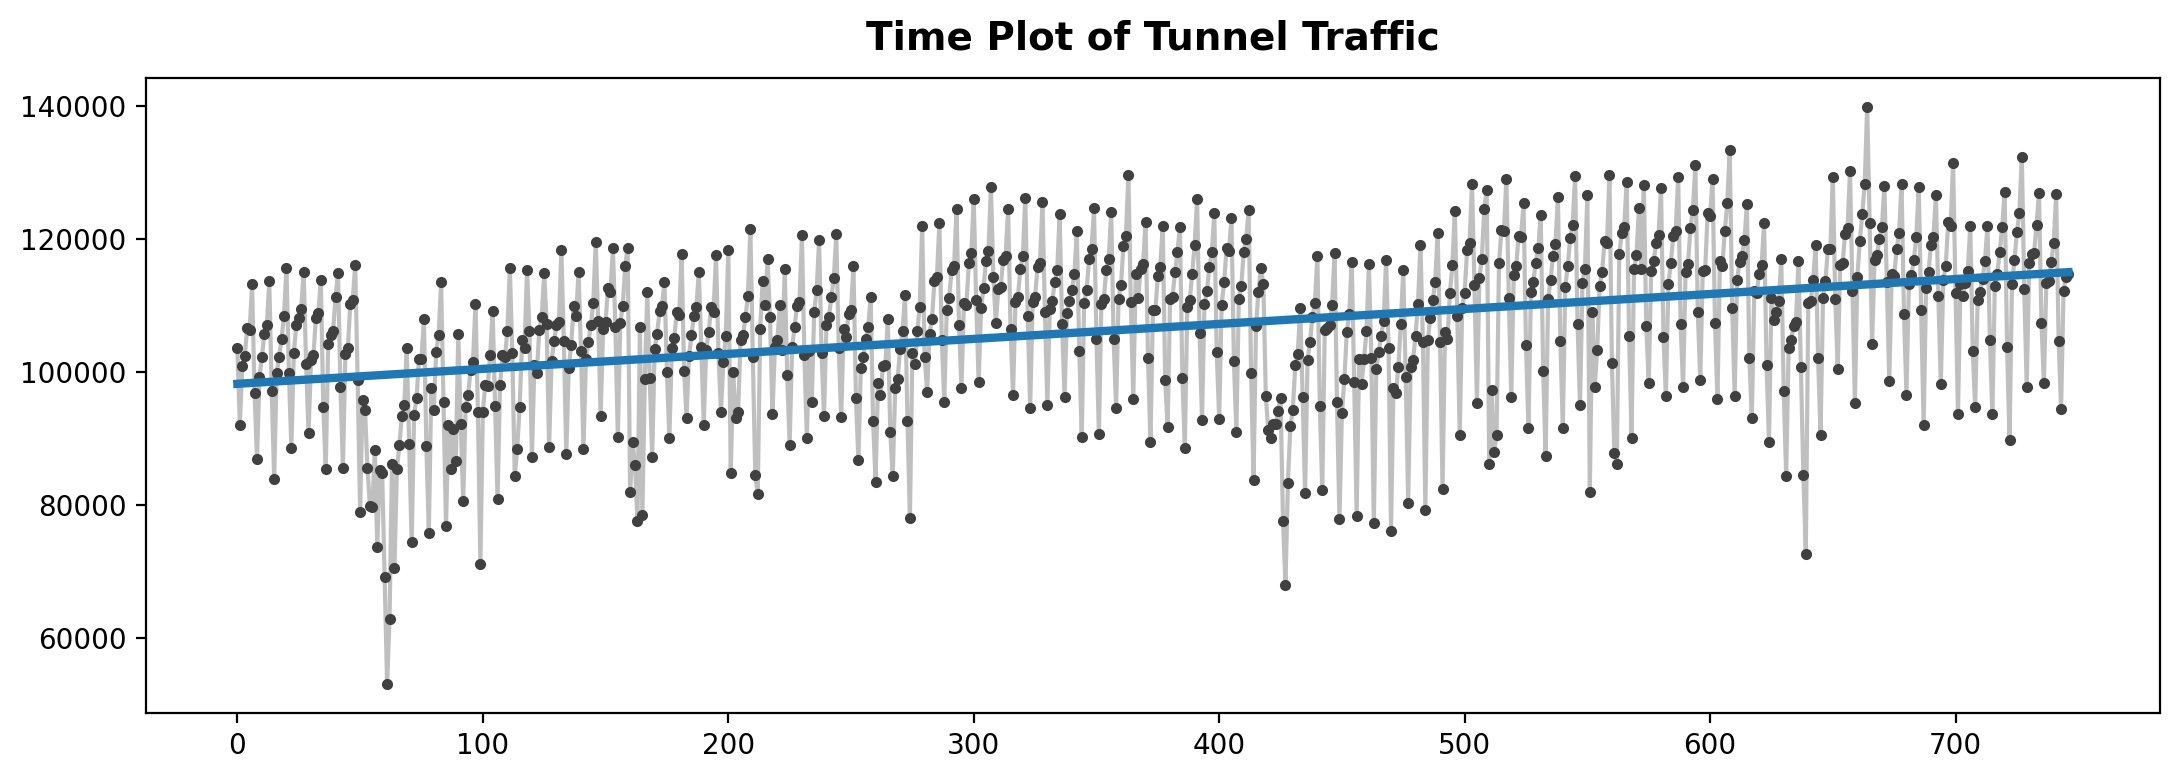

In [10]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

# Model Lag Feature Based

## Data Preparation

### Lag Feature

In [11]:
# Add lag feature
tunnel_dataset['Lag_1'] = tunnel_dataset['NumVehicles'].shift(1)
tunnel_dataset.head()

,Day,NumVehicles,Time,Lag_1
0,2003-11-01,103536,0,NaN
1,2003-11-02,92051,1,103536.0
2,2003-11-03,100795,2,92051.0
3,2003-11-04,102352,3,100795.0
4,2003-11-05,106569,4,102352.0


### Define Features & Labels

In [12]:
# Use the `Lag_1` as feature
X = tunnel_dataset.loc[:, ['Lag_1']]

# Drop missing values
X.dropna(inplace=True)

# Create target
y = tunnel_dataset.loc[:, 'NumVehicles']

# Drop missing X values in y
y, X = y.align(X, join='inner')

## Model Training

In [13]:
# Fit model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

## Inference

In [14]:
# Compute predictions
y_pred = pd.Series(model.predict(X), index=X.index)

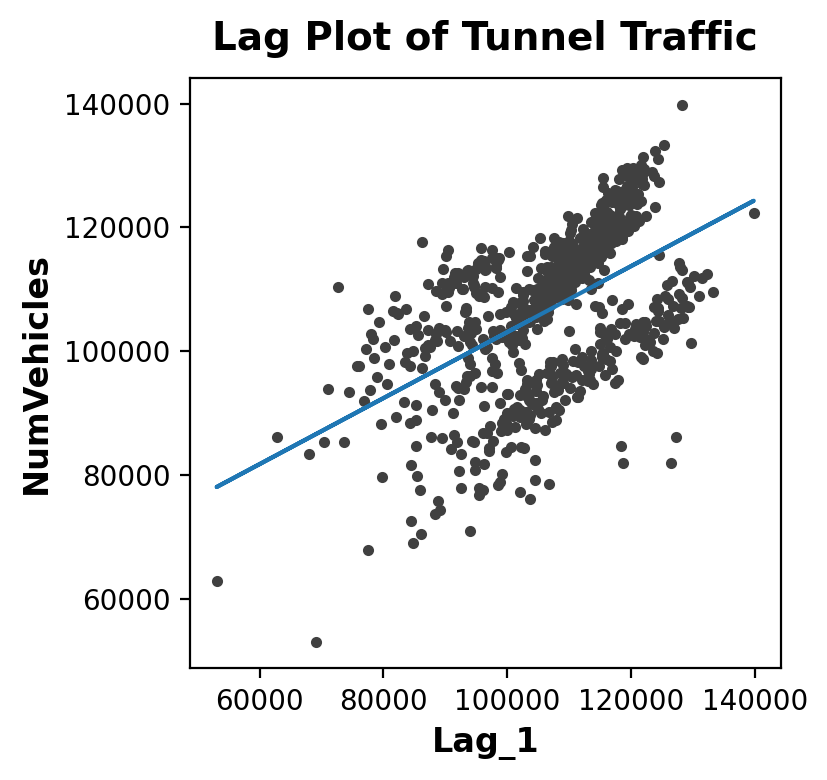

In [15]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

# Moving Average

The Moving Average plot helps to identify the kind of the trend the time series might have.
It is plotted by computing the average of the values of the time series within a sliding window of some pre-defined length.
It helps to overcome short-term seasonal changes and uncover the underlying trend pattern. It is used to see a trend without the "noise" added by seasonal changes.

<Axes: title={'center': 'Tunnel Traffic - 365-Day Moving Average'}, xlabel='Day'>

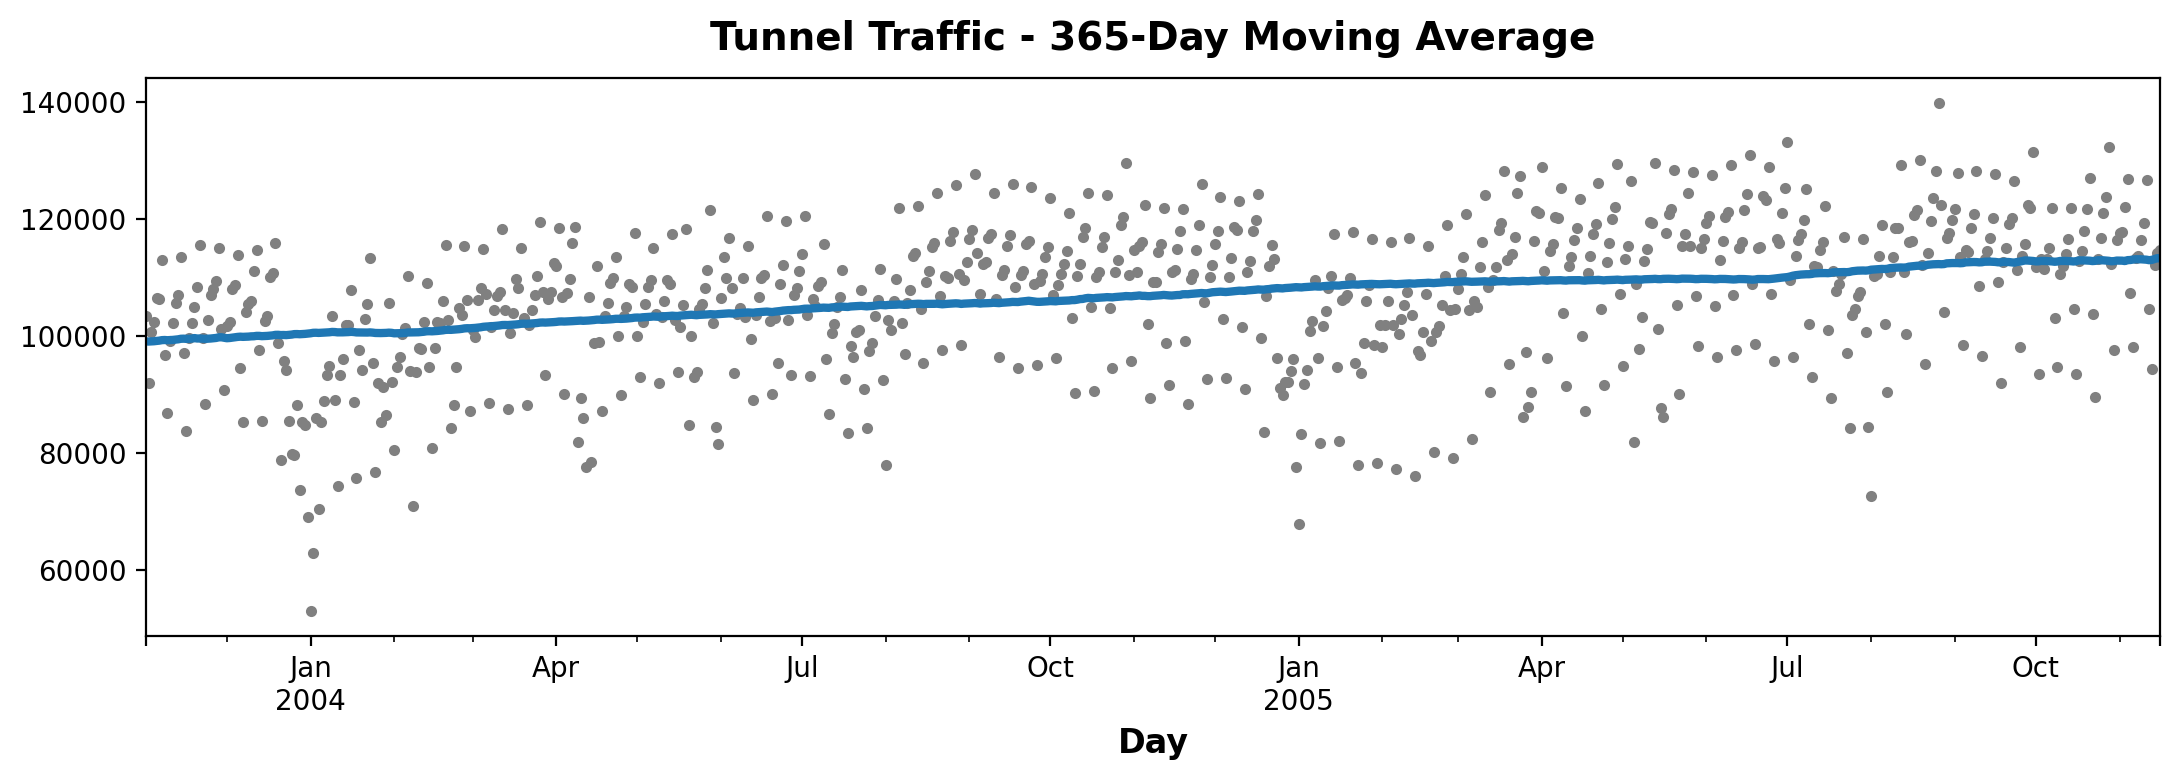

In [27]:
# Compute the moving average over the NumVehicles
tunnel_dataset_moving_average = tunnel_dataset.set_index('Day').to_period()['NumVehicles']

moving_average = tunnel_dataset_moving_average.rolling(
    window=365, # Window size
    center=True, # Place average at the center of the window
    min_periods=183
).mean()

# Plot data points
ax = tunnel_dataset_moving_average.plot(style=".", color="0.5")

# Plot the moving average line
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
)